<a href="https://colab.research.google.com/github/EvagAIML/Case-Study-V3/blob/main/EasyVisaCaseStudy_FullCode_ErikVagshenian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement

Business Context
Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers’ compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

Objective
In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

Facilitate the process of visa approvals.
Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

Data Description
The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

case_id: ID of each visa application
continent: Information of continent the employee
education_of_employee: Information of education of the employee
has_job_experience: Does the employee has any job experience? Y= Yes; N = No
requires_job_training: Does the employee require any job training? Y = Yes; N = No
no_of_employees: Number of employees in the employer’s company
yr_of_estab: Year in which the employer’s company was established
region_of_employment: Information of foreign worker’s intended region of employment in the US.
prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
case_status: Flag indicating if the Visa was certified or denied

### Summary:

The U.S. Office of Foreign Labor Certification (OFLC) reviews visa applications to decide whether they should be certified or denied. With rising application volumes, EasyVisa is developing a machine learning model to predict these outcomes based on key applicant and employer details like education, experience, wages, and job location. This will help automate and speed up decision-making while ensuring fairness and consistency.

Deductions:
This is a binary classification problem with a known y value and two outcomes: certified or denied. Both are equally important: predicting denials accurately prevents invalid approvals, while correctly identifying certifications ensures qualified applicants aren’t rejected. The model must therefore balance both outcomes to support efficient and equitable visa processing.

In [1]:
# ============================================================
# 0) Setup: Install & Imports
#    - Install once in Colab, then "Restart runtime" and run all cells
# ============================================================
!pip -q install --user numpy pandas scikit-learn matplotlib seaborn xgboost imbalanced-learn

### Summary:

Installs required Python packages (NumPy, Pandas, scikit-learn, Matplotlib, Seaborn, XGBoost, Imbalanced-learn) to enable EDA, modeling, and class-imbalance handling.

In [2]:
# ============================================================
# 1) Import Libraries & Globals
# ============================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style="whitegrid", context="notebook")

### Summary:


Imports all key libraries for data processing, visualization, model building, and evaluation. Establishes consistent settings, enables handling of class imbalance with SMOTE, and sets a random seed for reproducible machine learning results.

In [3]:
# ============================================================
# 2) Load Dataset
#    Source: GitHub CSV
# ============================================================
URL = "https://raw.githubusercontent.com/EvagAIML/Case-Study-V3/refs/heads/main/EasyVisa%20(12).csv"
df = pd.read_csv(URL)

print("Dataset loaded.")
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

print("\nFirst 5 rows:")
display(df.head())
print("\nLast 5 rows:")
display(df.tail())

Dataset loaded.
Shape: (25480, 12)

Columns: ['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'case_status']

First 5 rows:


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified



Last 5 rows:


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


### Summary:


The dataset contains 25,480 visa applications across 12 columns describing both employee and employer attributes. The first and last five rows show that records include a mix of categorical variables (such as continent, education, experience, and job region) and numerical variables (such as number of employees, year of establishment, and prevailing wage). This combination indicates a structured dataset suitable for a supervised classification problem, where the target variable case_status (Certified or Denied) reflects visa approval outcomes.

In [4]:
# ============================================================
# 3) Data Understanding (Types, Missingness, Target Balance)
# ============================================================
print("Dtypes:\n", df.dtypes)
print("\nMissing values (count):")
display(df.isna().sum().sort_values(ascending=False))

print("\nTarget distribution (raw):")
if "case_status" in df.columns:
    print(df["case_status"].value_counts(dropna=False))
else:
    raise ValueError("Missing target column 'case_status'.")

print("\nNumeric overview:")
display(df.select_dtypes(include="number").describe().T)

print("\nCategorical sample levels (top-5 by count):")
for c in df.select_dtypes(include="object").columns:
    print(f"\n{c}:")
    print(df[c].value_counts(dropna=False).head(5))

Dtypes:
 case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object
dtype: object

Missing values (count):


,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0



Target distribution (raw):
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

Numeric overview:


,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27



Categorical sample levels (top-5 by count):

case_id:
case_id
EZYV25480    1
EZYV01       1
EZYV02       1
EZYV03       1
EZYV04       1
Name: count, dtype: int64

continent:
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Name: count, dtype: int64

education_of_employee:
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64

has_job_experience:
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64

requires_job_training:
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64

region_of_employment:
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64

unit_of_wage:
unit_of_wage
Year     22962
Hour      2157
Week       272
Month       89
Name: count, dtype: int64

full_time_position:
full_time_position
Y    22773
N     2707

### Summary:

The statistical summary shows consistent numerical data overall, but the number of employees column contains negative values that will need to be corrected before analysis. Categorical variables such as continent, education level, and employment region have clear groupings, with Asia providing the majority of applications and most jobs listed as full-time.

Reviewing the counts for each category helps identify where certain groups or regions may be overrepresented, which is important for understanding potential bias in visa approval patterns. These insights will guide the necessary data cleaning and preparation steps before building the model.

In [5]:
# ============================================================
# 4) Primary Cleaning (Essential, Non-destructive)
#    - Normalize Y/N text
#    - Fix negative employees
#    - Annualize wage
#    - Validate year
#    - Encode target -> numeric {DENIED:0, CERTIFIED:1}
# ============================================================
df_clean = df.copy()

# Normalize simple Y/N-like fields
def norm_yn(x):
    s = str(x).strip().upper()
    if s in {"Y","YES","TRUE","T","1"}: return "YES"
    if s in {"N","NO","FALSE","F","0"}: return "NO"
    return s

for c in ["has_job_experience", "requires_job_training", "full_time_position"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].map(norm_yn)

# Strip/upper categorical text
for c in df_clean.select_dtypes(include="object").columns:
    df_clean[c] = df_clean[c].astype(str).str.strip().str.upper()

# Fix negatives in employees
if "no_of_employees" in df_clean.columns:
    emp = pd.to_numeric(df_clean["no_of_employees"], errors="coerce")
    neg_mask = emp < 0
    fixed = int(neg_mask.sum())
    if fixed:
        df_clean.loc[neg_mask, "no_of_employees"] = emp[~neg_mask].median()
    print(f"Negative 'no_of_employees' corrected: {fixed}")

# Annualize wage
if {"prevailing_wage","unit_of_wage"}.issubset(df_clean.columns):
    u = df_clean["unit_of_wage"].astype(str).str.upper().str.strip()
    factors = {"HOUR":2080,"HOURLY":2080,"WEEK":52,"WEEKLY":52,"MONTH":12,"MONTHLY":12,"YEAR":1,"YEARLY":1}
    f = u.map(factors).fillna(1)
    w = pd.to_numeric(df_clean["prevailing_wage"], errors="coerce")
    df_clean["prevailing_wage_yearly"] = w * f
    print("Created 'prevailing_wage_yearly'.")

# Validate year range
if "yr_of_estab" in df_clean.columns:
    yrs = pd.to_numeric(df_clean["yr_of_estab"], errors="coerce")
    valid = yrs.between(1800, 2025)
    dropped = int((~valid).sum())
    df_clean = df_clean.loc[valid].copy()
    print(f"Rows removed for invalid 'yr_of_estab': {dropped}")

# Encode target to numeric (STRICT)
df_clean["case_status"] = df_clean["case_status"].map({"DENIED":0, "CERTIFIED":1})
dropped_tgt = df_clean["case_status"].isna().sum()
df_clean = df_clean.dropna(subset=["case_status"])
df_clean["case_status"] = df_clean["case_status"].astype(int)
print(f"Dropped rows with undefined target: {dropped_tgt}")

# Drop fully-unique IDs
for col in ["case_id","id","caseid"]:
    if col in df_clean.columns and df_clean[col].nunique(dropna=False) >= 0.99*len(df_clean):
        df_clean.drop(columns=[col], inplace=True)

print("\nCleaned shape:", df_clean.shape)
display(df_clean.head())

Negative 'no_of_employees' corrected: 33
Created 'prevailing_wage_yearly'.
Rows removed for invalid 'yr_of_estab': 0
Dropped rows with undefined target: 0

Cleaned shape: (25480, 12)


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,prevailing_wage_yearly
0,ASIA,HIGH SCHOOL,NO,NO,14513,2007,WEST,592.2029,HOUR,YES,0,1231782.032
1,ASIA,MASTER'S,YES,NO,2412,2002,NORTHEAST,83425.6500,YEAR,YES,1,83425.650
2,ASIA,BACHELOR'S,NO,YES,44444,2008,WEST,122996.8600,YEAR,YES,0,122996.860
3,ASIA,BACHELOR'S,NO,NO,98,1897,WEST,83434.0300,YEAR,YES,0,83434.030
4,AFRICA,MASTER'S,YES,NO,1082,2005,SOUTH,149907.3900,YEAR,YES,1,149907.390


### Summary:

The data was cleaned and standardized to prepare it for modeling. Text-based fields such as Yes/No responses were normalized to a consistent format, and all categorical text was converted to uppercase for uniformity. Invalid negative values in the number of employees column were corrected using the median of valid values, ensuring numerical consistency.

Prevailing wages were standardized to an annual basis using appropriate conversion factors (e.g., hourly to yearly), and unrealistic establishment years were removed to maintain temporal validity. The target variable case_status was encoded numerically, with Denied as 0 and Certified as 1, allowing for machine learning compatibility.

After cleaning, the dataset maintained all 25,480 valid records, now consistent, structured, and ready for feature engineering and model training.

Numeric columns: ['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'case_status', 'prevailing_wage_yearly']
Categorical columns: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


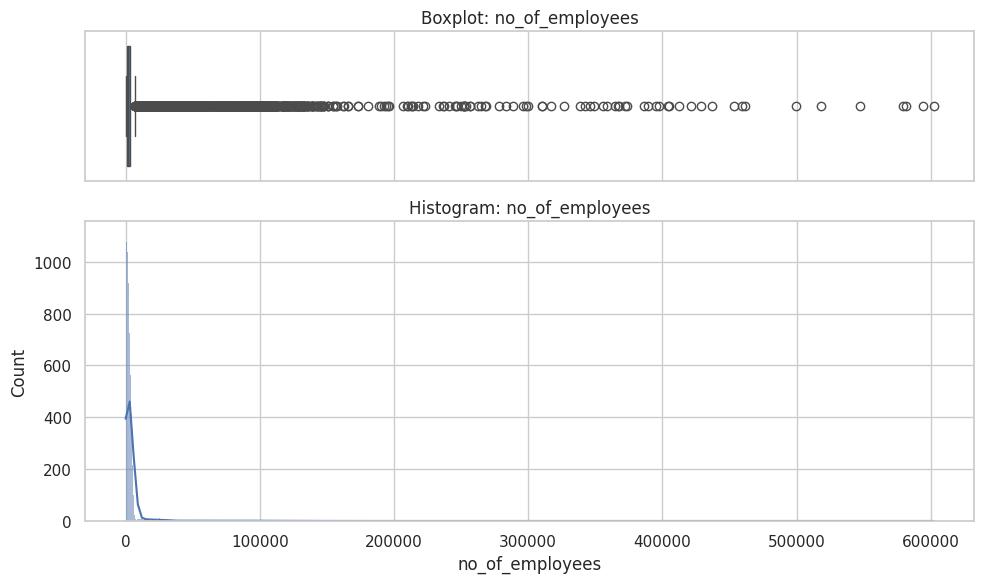

count     25480.000000
mean       5669.801531
std       22877.371642
min          12.000000
25%        1028.000000
50%        2112.000000
75%        3504.000000
max      602069.000000 



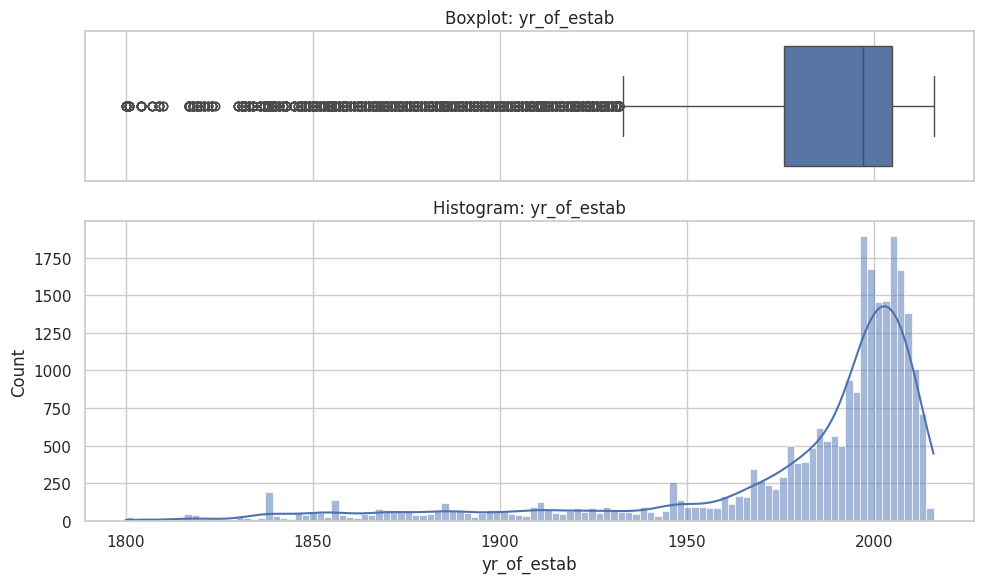

count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
25%       1976.000000
50%       1997.000000
75%       2005.000000
max       2016.000000 



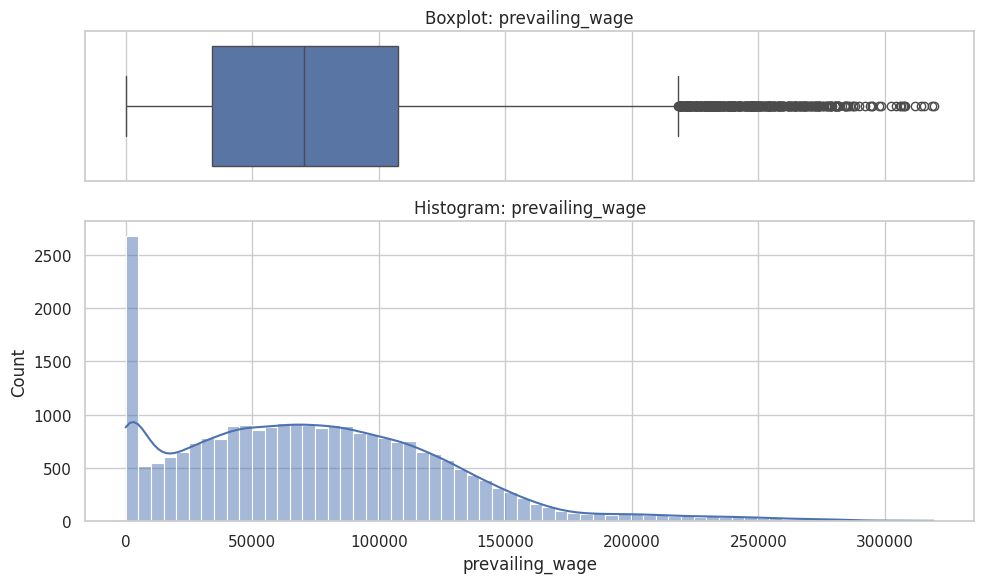

count     25480.000000
mean      74455.814592
std       52815.942327
min           2.136700
25%       34015.480000
50%       70308.210000
75%      107735.512500
max      319210.270000 



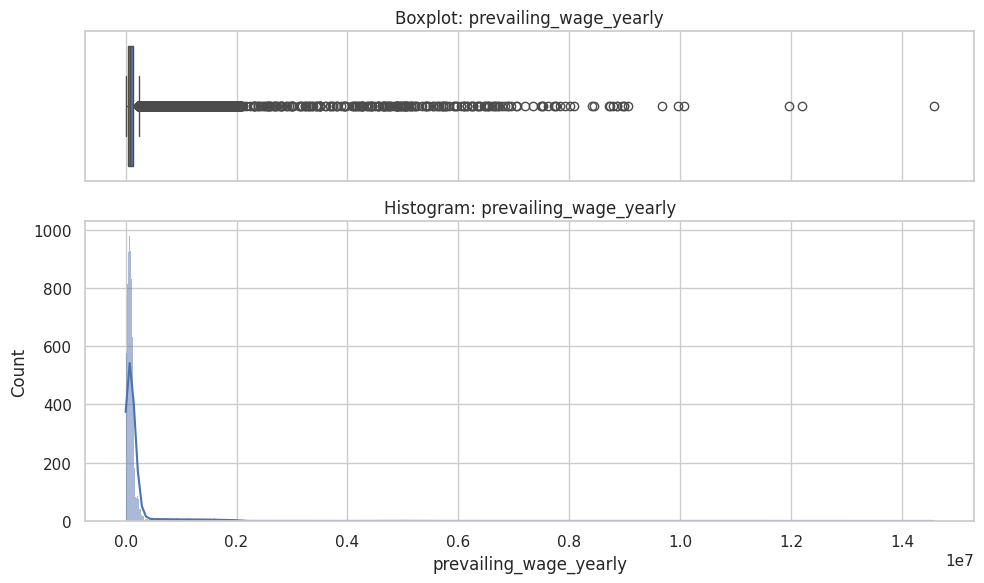

count    2.548000e+04
mean     1.973912e+05
std      5.785917e+05
min      1.000000e+02
25%      4.710796e+04
50%      8.283946e+04
75%      1.248250e+05
max      1.456915e+07 



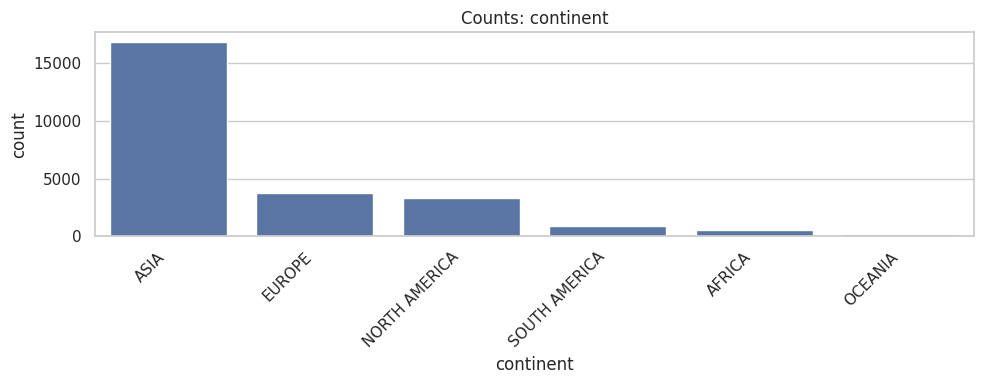

continent
ASIA             16861
EUROPE            3732
NORTH AMERICA     3292
SOUTH AMERICA      852
AFRICA             551
OCEANIA            192
Name: count, dtype: int64 



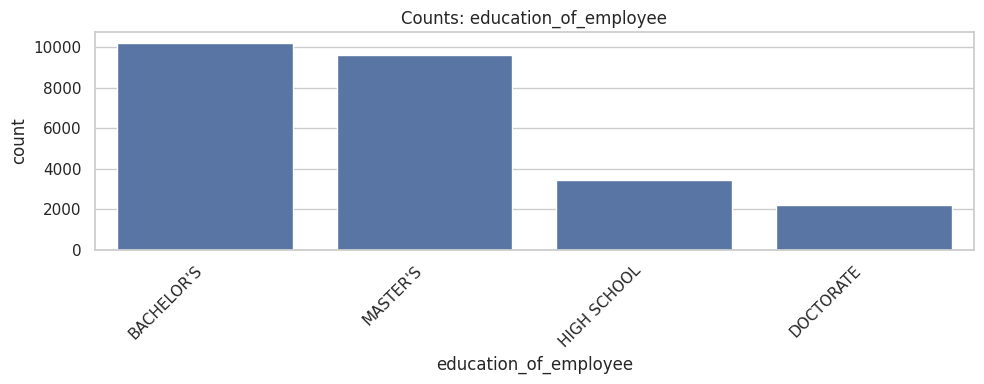

education_of_employee
BACHELOR'S     10234
MASTER'S        9634
HIGH SCHOOL     3420
DOCTORATE       2192
Name: count, dtype: int64 



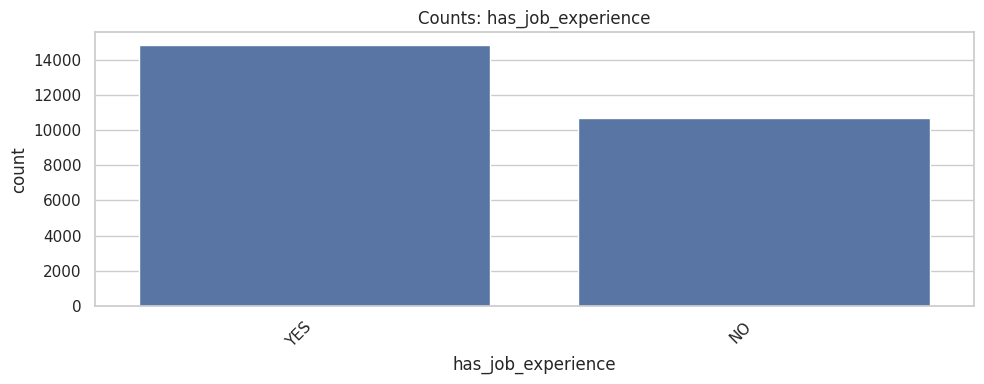

has_job_experience
YES    14802
NO     10678
Name: count, dtype: int64 



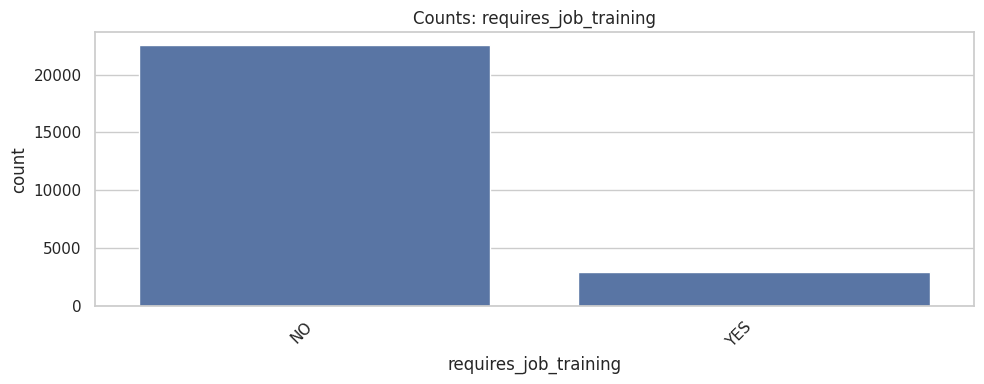

requires_job_training
NO     22525
YES     2955
Name: count, dtype: int64 



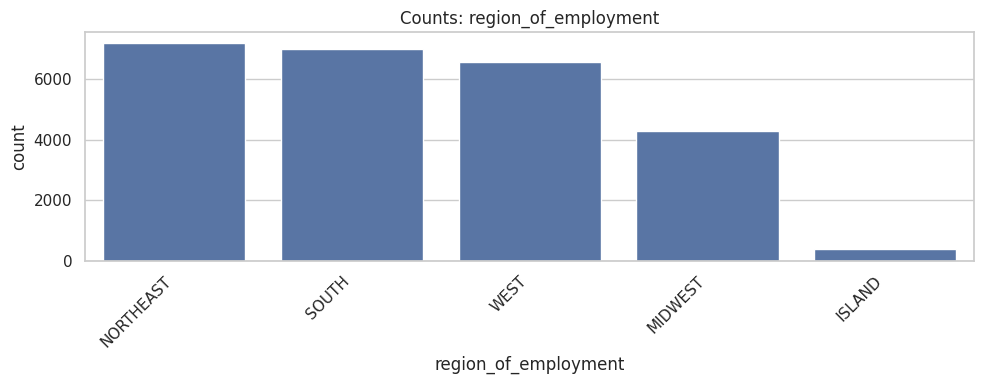

region_of_employment
NORTHEAST    7195
SOUTH        7017
WEST         6586
MIDWEST      4307
ISLAND        375
Name: count, dtype: int64 



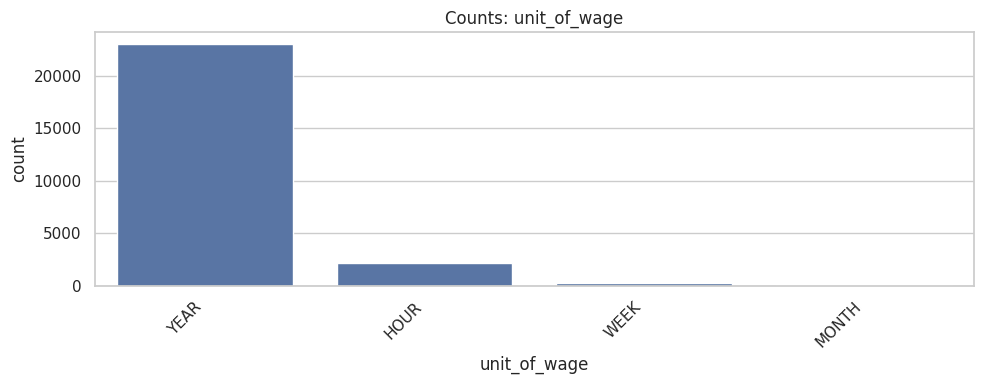

unit_of_wage
YEAR     22962
HOUR      2157
WEEK       272
MONTH       89
Name: count, dtype: int64 



In [6]:
# ============================================================
# 5) Exploratory Data Analysis (Univariate)
#    - Numeric: hist + box, key stats
#    - Categorical: counts
# ============================================================
num_cols = df_clean.select_dtypes(include="number").columns.tolist()
cat_cols = df_clean.select_dtypes(exclude="number").columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Numeric Univariate: plot first 4 numerics for brevity (adjust as needed)
for c in [x for x in num_cols if x != "case_status"][:6]:
    fig, axs = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios':[1,2]}, sharex=True)
    sns.boxplot(x=df_clean[c], ax=axs[0])
    sns.histplot(df_clean[c], kde=True, ax=axs[1])
    axs[0].set_title(f"Boxplot: {c}")
    axs[1].set_title(f"Histogram: {c}")
    plt.tight_layout(); plt.show()
    print(df_clean[c].describe().to_string(), "\n")

# Categorical Univariate: frequency bars
for c in [x for x in cat_cols if x != "CASE_STATUS"][:6]:
    plt.figure(figsize=(10,4))
    order = df_clean[c].value_counts().index
    sns.countplot(data=df_clean, x=c, order=order)
    plt.title(f"Counts: {c}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()
    print(df_clean[c].value_counts(dropna=False).head(10), "\n")

### Summary:

Univariate analysis shows that numerical features such as prevailing wage and number of employees have wide variation, with wages ranging from about 2 to over 300,000 dollars and company sizes extending from very small to extremely large. The distribution of establishment years is concentrated between 1970 and 2016, consistent with modern employers.

Education levels are led by bachelor’s and master’s degrees, suggesting most applicants are highly qualified. The region of employment is spread across all major U.S. regions, though most applications are concentrated in the Northeast, South, and West. Applicants with prior job experience make up the majority, while relatively few require job training, which could indicate stronger readiness for skilled roles.

The target variable case_status shows that certifications significantly outnumber denials, meaning most applications are approved. These patterns help identify early trends in how education, region, and experience may influence visa outcomes before deeper model-based analysis.

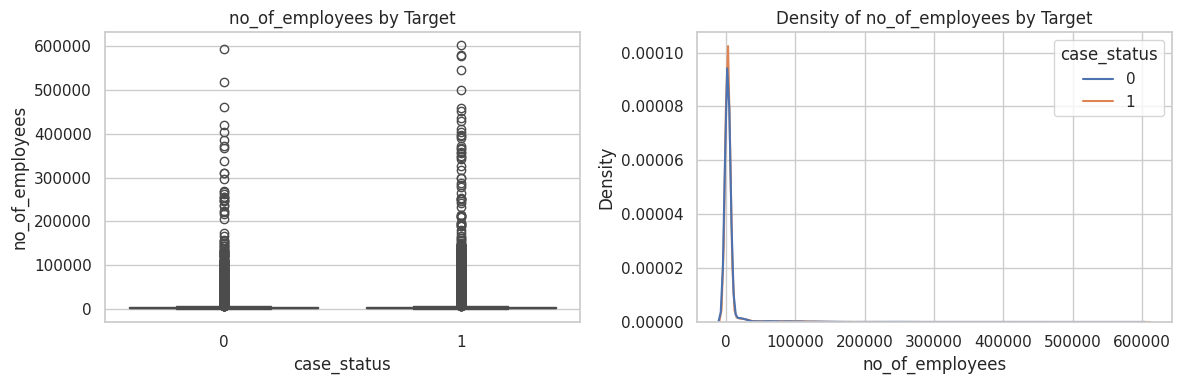

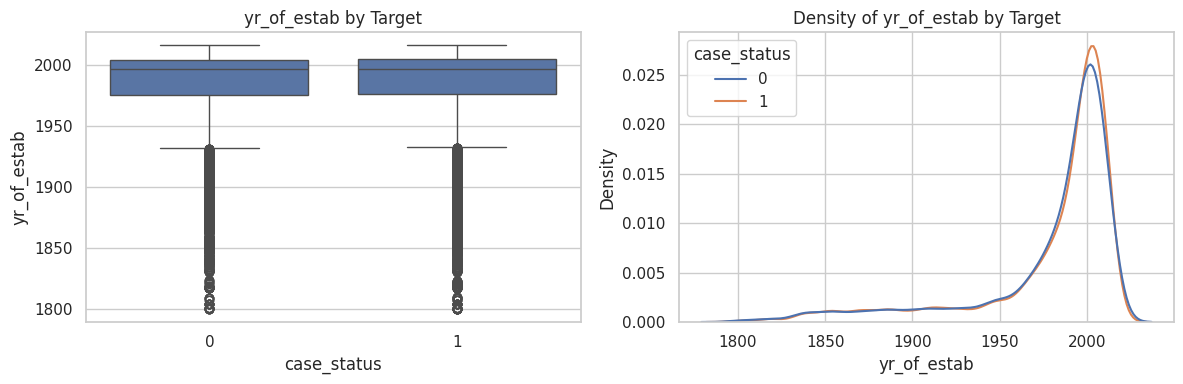

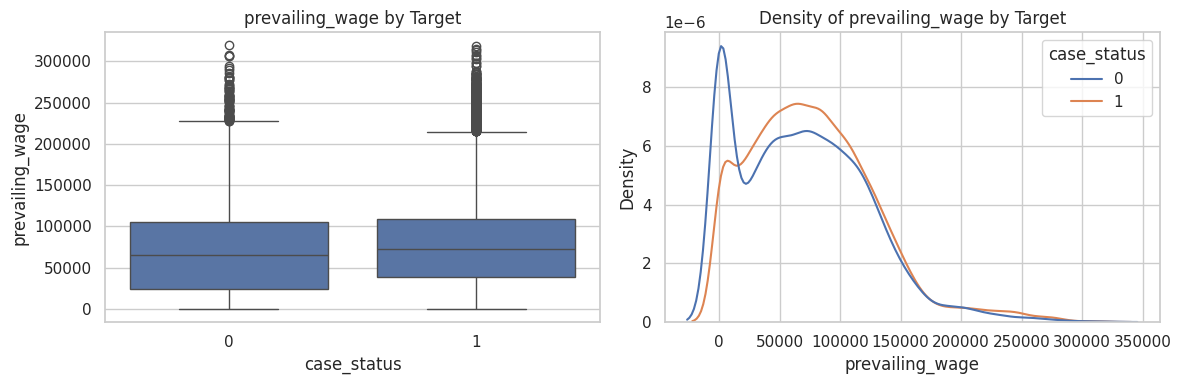

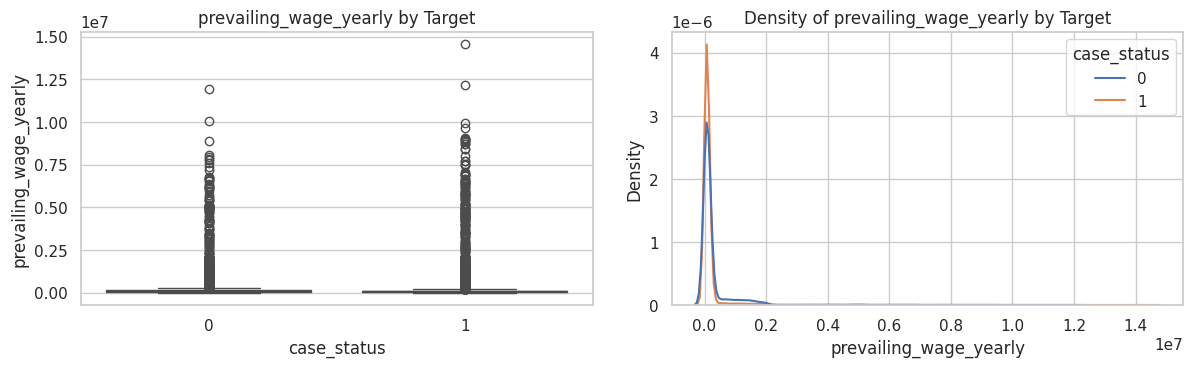

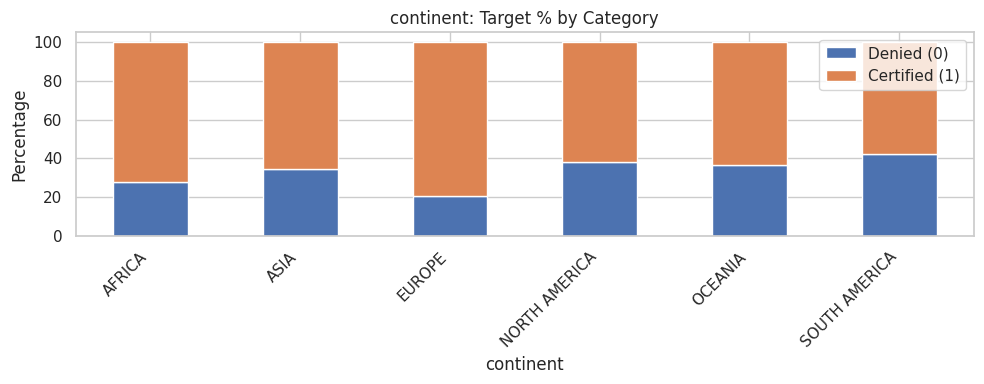

case_status,0,1,All
continent,,,
AFRICA,154,397,551
ASIA,5849,11012,16861
EUROPE,775,2957,3732
NORTH AMERICA,1255,2037,3292
OCEANIA,70,122,192
SOUTH AMERICA,359,493,852
All,8462,17018,25480


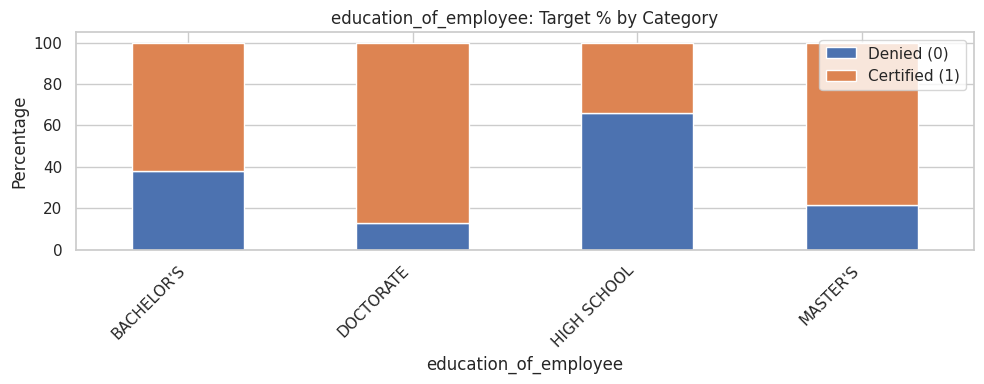

case_status,0,1,All
education_of_employee,,,
BACHELOR'S,3867,6367,10234
DOCTORATE,280,1912,2192
HIGH SCHOOL,2256,1164,3420
MASTER'S,2059,7575,9634
All,8462,17018,25480


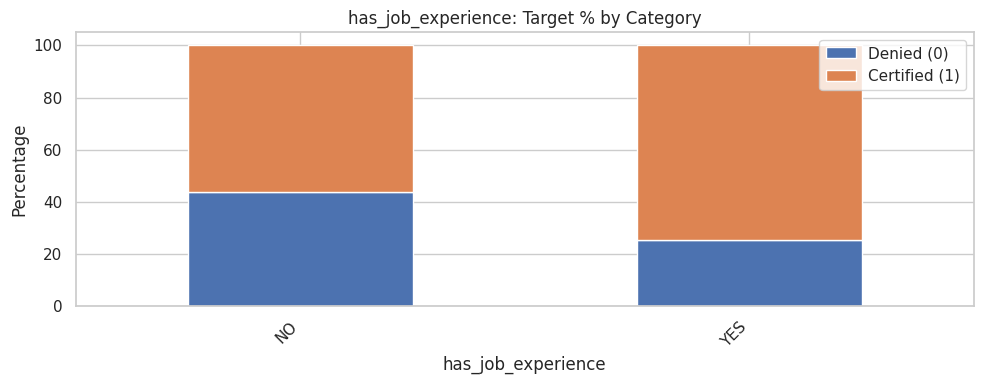

case_status,0,1,All
has_job_experience,,,
NO,4684,5994,10678
YES,3778,11024,14802
All,8462,17018,25480


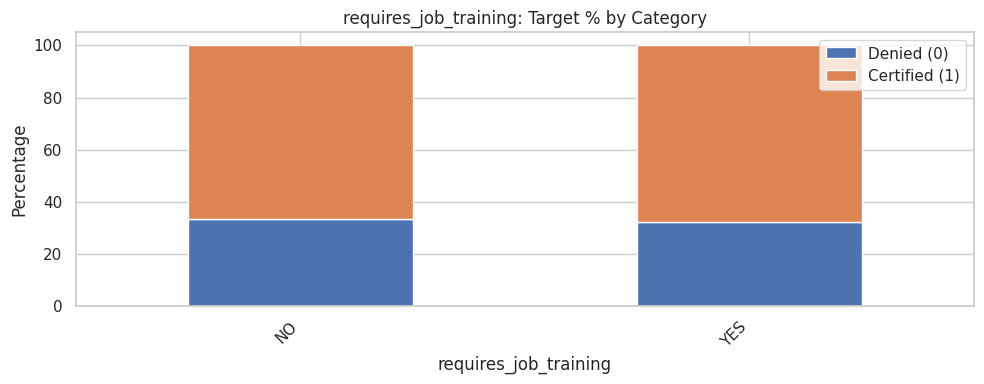

case_status,0,1,All
requires_job_training,,,
NO,7513,15012,22525
YES,949,2006,2955
All,8462,17018,25480


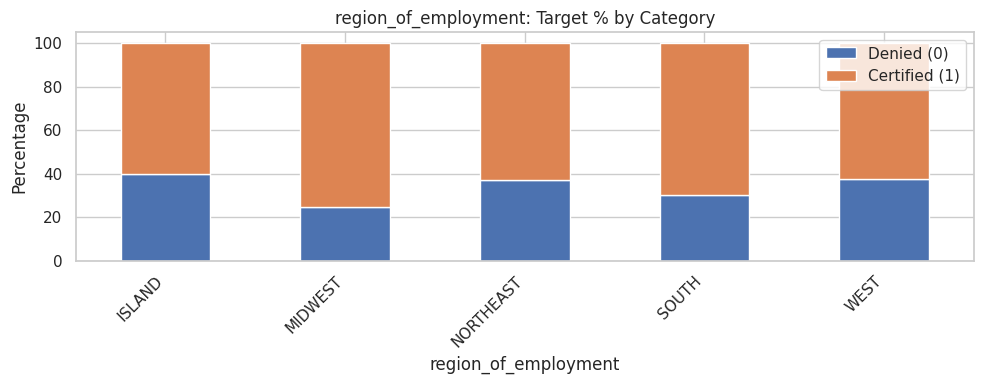

case_status,0,1,All
region_of_employment,,,
ISLAND,149,226,375
MIDWEST,1054,3253,4307
NORTHEAST,2669,4526,7195
SOUTH,2104,4913,7017
WEST,2486,4100,6586
All,8462,17018,25480


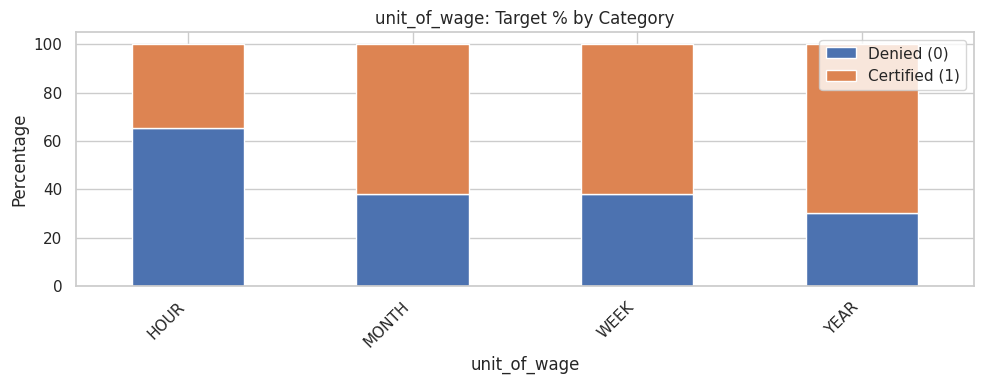

case_status,0,1,All
unit_of_wage,,,
HOUR,1410,747,2157
MONTH,34,55,89
WEEK,103,169,272
YEAR,6915,16047,22962
All,8462,17018,25480


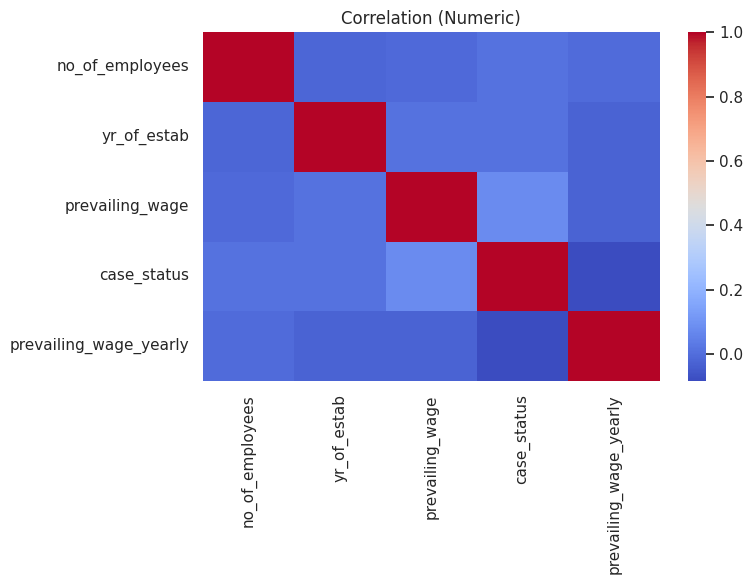

In [7]:
# ============================================================
# 6) Exploratory Data Analysis (Bivariate)
#    - Numeric vs target: box & density
#    - Categorical vs target: stacked proportions
#    - Correlation heatmap (numeric only)
# ============================================================

target = "case_status"

# Numeric vs target
for c in [x for x in num_cols if x != target][:6]:
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    sns.boxplot(data=df_clean, x=target, y=c, ax=axs[0])
    sns.kdeplot(data=df_clean, x=c, hue=target, common_norm=False, ax=axs[1])
    axs[0].set_title(f"{c} by Target")
    axs[1].set_title(f"Density of {c} by Target")
    plt.tight_layout(); plt.show()

# Categorical vs target
def stacked_barplot(data, feature, target):
    ctab = pd.crosstab(data[feature], data[target], normalize="index")*100
    ctab.plot(kind="bar", stacked=True, figsize=(10,4))
    plt.title(f"{feature}: Target % by Category")
    plt.ylabel("Percentage")
    plt.legend(["Denied (0)","Certified (1)"], loc="upper right")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()
    display(pd.crosstab(data[feature], data[target], margins=True))

for c in [x for x in cat_cols if x != "CASE_STATUS"][:6]:
    stacked_barplot(df_clean, c, target)

# Correlation heatmap (numeric)
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.select_dtypes(include="number").corr(), cmap="coolwarm", annot=False)
plt.title("Correlation (Numeric)"); plt.tight_layout(); plt.show()

In [8]:
# ============================================================
# 7) Split (60/20/20) & Preprocess
#    - Stratified split
#    - ColumnTransformer with impute+scale+OHE
# ============================================================
X = df_clean.drop(columns=[target])
y = df_clean[target].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, stratify=y, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)

def pct(s): return (s.value_counts(normalize=True)*100).round(2).to_dict()
print("Shapes -> Train:", X_train.shape, "| Valid:", X_valid.shape, "| Test:", X_test.shape)
print("Class % -> Train:", pct(y_train), "| Valid:", pct(y_valid), "| Test:", pct(y_test))

num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(exclude="number").columns.tolist()

numeric_tf = Pipeline(steps=[("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
# Compat across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_tf = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
], remainder="drop")

print("Preprocessor ready.")
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Shapes -> Train: (15288, 11) | Valid: (5096, 11) | Test: (5096, 11)
Class % -> Train: {1: 66.79, 0: 33.21} | Valid: {1: 66.8, 0: 33.2} | Test: {1: 66.78, 0: 33.22}
Preprocessor ready.
Numeric: ['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'prevailing_wage_yearly']
Categorical: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


In [9]:
# ============================================================
# 8) Model Building — ORIGINAL DATA (Class Weights)
#    - 5+ models
#    - Evaluate on VALID (untouched)
# ============================================================
def make_plain(model):
    return Pipeline([("pre", preprocessor), ("clf", model)])

class_weights = {0: 2.0, 1: 1.0}  # emphasize DENIED (0)
models_orig = {
    "Logistic (weighted)":   make_plain(LogisticRegression(solver="liblinear", class_weight=class_weights, max_iter=2000, random_state=RANDOM_STATE)),
    "Decision Tree (weighted)": make_plain(DecisionTreeClassifier(class_weight=class_weights, random_state=RANDOM_STATE)),
    "Random Forest (weighted)": make_plain(RandomForestClassifier(n_estimators=300, class_weight=class_weights, n_jobs=-1, random_state=RANDOM_STATE)),
    "Bagging (DT base)":     make_plain(BaggingClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    "AdaBoost":              make_plain(AdaBoostClassifier(n_estimators=300, random_state=RANDOM_STATE)),
    "Gradient Boosting":     make_plain(GradientBoostingClassifier(random_state=RANDOM_STATE)),
}
if XGB_OK:
    models_orig["XGBoost"] = make_plain(
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=400,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=-1
        )
    )

rows, fitted_orig = [], {}
for name, pipe in models_orig.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_prob = pipe.predict_proba(X_valid)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec  = recall_score(y_valid, y_pred)                 # CERTIFIED recall
    f1   = f1_score(y_valid, y_pred)
    auc  = roc_auc_score(y_valid, y_prob) if y_prob is not None else np.nan

    # Also compute DENIED metrics (class 0) for completeness
    cm = confusion_matrix(y_valid, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec_denied = tn/(tn+fp) if (tn+fp) else np.nan

    rows.append([name, acc, prec, rec, f1, auc, spec_denied])
    fitted_orig[name] = pipe

orig_perf = pd.DataFrame(rows, columns=["Model","Accuracy","Precision(1)","Recall(1)","F1(1)","ROC_AUC","Spec(0)"])\
              .sort_values(by=["F1(1)","ROC_AUC"], ascending=False).reset_index(drop=True)

print("=== ORIGINAL DATA — Validation ===")
display(orig_perf.round(4))

=== ORIGINAL DATA — Validation ===


,Model,Accuracy,Precision(1),Recall(1),F1(1),ROC_AUC,Spec(0)
0,Gradient Boosting,0.7437,0.7746,0.8693,0.8192,0.7756,0.4911
1,XGBoost,0.7398,0.7731,0.8640,0.8160,0.7675,0.4900
2,AdaBoost,0.7308,0.7555,0.8825,0.8141,0.7653,0.4255
3,Random Forest (weighted),0.7290,0.7678,0.8519,0.8077,0.7521,0.4817
4,Bagging (DT base),0.7233,0.7654,0.8446,0.8031,0.7512,0.4793
5,Logistic (weighted),0.6978,0.8125,0.7118,0.7588,0.7669,0.6696
6,Decision Tree (weighted),0.6635,0.7420,0.7606,0.7512,0.6143,0.4681


In [10]:
# ============================================================
# 9) Model Building — OVERSAMPLED TRAIN (SMOTE)
#    - Resample ONLY in the training fold (pipeline)
#    - Evaluate on VALID (untouched)
# ============================================================
def make_smote(model):
    return ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", model)
    ])

models_smote = {
    "Logistic + SMOTE (weighted)": make_smote(LogisticRegression(solver="liblinear", class_weight=class_weights, max_iter=2000, random_state=RANDOM_STATE)),
    "Decision Tree + SMOTE (weighted)": make_smote(DecisionTreeClassifier(class_weight=class_weights, random_state=RANDOM_STATE)),
    "Random Forest + SMOTE (weighted)": make_smote(RandomForestClassifier(n_estimators=300, class_weight=class_weights, n_jobs=-1, random_state=RANDOM_STATE)),
    "Gradient Boosting + SMOTE": make_smote(GradientBoostingClassifier(random_state=RANDOM_STATE)),
    "AdaBoost + SMOTE": make_smote(AdaBoostClassifier(n_estimators=300, random_state=RANDOM_STATE)),
}

rows, fitted_smote = [], {}
for name, pipe in models_smote.items():
    pipe.fit(X_train, y_train)  # SMOTE applies to TRAIN only
    y_pred = pipe.predict(X_valid)
    y_prob = pipe.predict_proba(X_valid)[:,1]

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec  = recall_score(y_valid, y_pred)
    f1   = f1_score(y_valid, y_pred)
    auc  = roc_auc_score(y_valid, y_prob)

    cm = confusion_matrix(y_valid, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec_denied = tn/(tn+fp) if (tn+fp) else np.nan

    rows.append([name, acc, prec, rec, f1, auc, spec_denied])
    fitted_smote[name] = pipe

smote_perf = pd.DataFrame(rows, columns=["Model","Accuracy","Precision(1)","Recall(1)","F1(1)","ROC_AUC","Spec(0)"])\
              .sort_values(by=["F1(1)","ROC_AUC"], ascending=False).reset_index(drop=True)

print("=== OVERSAMPLED TRAIN (SMOTE) — Validation ===")
display(smote_perf.round(4))

=== OVERSAMPLED TRAIN (SMOTE) — Validation ===


,Model,Accuracy,Precision(1),Recall(1),F1(1),ROC_AUC,Spec(0)
0,Random Forest + SMOTE (weighted),0.7094,0.7816,0.7841,0.7828,0.7488,0.5591
1,Gradient Boosting + SMOTE,0.7170,0.8140,0.7471,0.7791,0.7732,0.6566
2,AdaBoost + SMOTE,0.7019,0.8041,0.7321,0.7664,0.7614,0.6413
3,Decision Tree + SMOTE (weighted),0.6523,0.7556,0.7086,0.7314,0.6238,0.5390
4,Logistic + SMOTE (weighted),0.6160,0.8802,0.4921,0.6312,0.7660,0.8652


In [11]:
# ============================================================
# 10) Model Building — UNDERSAMPLED TRAIN
#     - Undersample ONLY the training split (pipeline)
#     - Evaluate on VALID (untouched)
# ============================================================
def make_under(model):
    return ImbPipeline([
        ("pre", preprocessor),
        ("under", RandomUnderSampler(random_state=RANDOM_STATE)),
        ("clf", model)
    ])

models_under = {
    "Logistic + Under (weighted)": make_under(LogisticRegression(solver="liblinear", class_weight=class_weights, max_iter=2000, random_state=RANDOM_STATE)),
    "Decision Tree + Under (weighted)": make_under(DecisionTreeClassifier(class_weight=class_weights, random_state=RANDOM_STATE)),
    "Random Forest + Under (weighted)": make_under(RandomForestClassifier(n_estimators=300, class_weight=class_weights, n_jobs=-1, random_state=RANDOM_STATE)),
}

rows, fitted_under = [], {}
for name, pipe in models_under.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_prob = pipe.predict_proba(X_valid)[:,1]

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec  = recall_score(y_valid, y_pred)
    f1   = f1_score(y_valid, y_pred)
    auc  = roc_auc_score(y_valid, y_prob)

    cm = confusion_matrix(y_valid, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec_denied = tn/(tn+fp) if (tn+fp) else np.nan

    rows.append([name, acc, prec, rec, f1, auc, spec_denied])
    fitted_under[name] = pipe

under_perf = pd.DataFrame(rows, columns=["Model","Accuracy","Precision(1)","Recall(1)","F1(1)","ROC_AUC","Spec(0)"])\
              .sort_values(by=["F1(1)","ROC_AUC"], ascending=False).reset_index(drop=True)

print("=== UNDERSAMPLED TRAIN — Validation ===")
display(under_perf.round(4))

=== UNDERSAMPLED TRAIN — Validation ===


,Model,Accuracy,Precision(1),Recall(1),F1(1),ROC_AUC,Spec(0)
0,Random Forest + Under (weighted),0.6862,0.8065,0.6977,0.7481,0.7492,0.6631
1,Decision Tree + Under (weighted),0.6172,0.7527,0.6357,0.6893,0.6078,0.5798
2,Logistic + Under (weighted),0.6085,0.8835,0.4768,0.6193,0.7662,0.8735


In [12]:
# ============================================================
# 11) Pick Top 3 Candidates for Tuning (from the three tables)
#     - Common strong choices in this problem: Gradient Boosting, Random Forest (weighted), Logistic (weighted)
# ============================================================
def pick_top(df, k=3):
    return df.head(k)["Model"].tolist()

candidates = list(dict.fromkeys(pick_top(orig_perf, 3) + pick_top(smote_perf, 3) + pick_top(under_perf, 3)))
print("Candidates for tuning:")
for c in candidates: print(" -", c)

Candidates for tuning:
 - Gradient Boosting
 - XGBoost
 - AdaBoost
 - Random Forest + SMOTE (weighted)
 - Gradient Boosting + SMOTE
 - AdaBoost + SMOTE
 - Random Forest + Under (weighted)
 - Decision Tree + Under (weighted)
 - Logistic + Under (weighted)


In [13]:
# ============================================================
# 12) Hyperparameter Tuning (Randomized/Grid)
#     - Tuning 3 models with F1 (positive=1) scorer
# ============================================================
from scipy.stats import randint, uniform, loguniform
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def build_model_by_name(name):
    # Re-create fresh pipelines that match the chosen names
    if name == "Gradient Boosting" or name == "Gradient Boosting + SMOTE":
        base = GradientBoostingClassifier(random_state=RANDOM_STATE)
        pipe = make_plain(base) if "SMOTE" not in name else make_smote(base)
        params = {
            "clf__n_estimators": [200, 300, 500],
            "clf__learning_rate": [0.05, 0.1, 0.2],
            "clf__max_depth": [2, 3, 4],
            "clf__subsample": [0.8, 1.0]
        }
        return pipe, params

    if "Random Forest" in name:
        base = RandomForestClassifier(n_estimators=300, class_weight=class_weights, random_state=RANDOM_STATE, n_jobs=-1)
        if "SMOTE" in name:
            pipe = make_smote(base)
        elif "Under" in name:
            pipe = make_under(base)
        else:
            pipe = make_plain(base)
        params = {
            "clf__n_estimators": [300, 500, 800],
            "clf__max_depth": [None, 8, 12],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ["sqrt", "log2", None]
        }
        return pipe, params

    if "Logistic" in name:
        base = LogisticRegression(solver="liblinear", class_weight=class_weights, random_state=RANDOM_STATE, max_iter=3000)
        if "SMOTE" in name:
            pipe = make_smote(base)
        elif "Under" in name:
            pipe = make_under(base)
        else:
            pipe = make_plain(base)
        params = {
            "clf__C": loguniform(1e-3, 1e2),
            "clf__penalty": ["l1", "l2"]
        }
        return pipe, params

    # Fallback: Gradient Boosting
    base = GradientBoostingClassifier(random_state=RANDOM_STATE)
    pipe = make_plain(base)
    params = {"clf__n_estimators":[200,300], "clf__learning_rate":[0.05,0.1]}
    return pipe, params

tuned_models = {}
tuning_rows = []
for name in candidates[:3]:  # limit to three for time
    pipe, param_dist = build_model_by_name(name)
    tuner = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=20,
        scoring="f1",   # positive class = 1
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        refit=True,
        verbose=0
    )
    tuner.fit(X_train, y_train)
    tuned = tuner.best_estimator_
    tuned_models[name] = tuned

    # Validate
    y_pred = tuned.predict(X_valid)
    try:
        y_prob = tuned.predict_proba(X_valid)[:,1]
        auc = roc_auc_score(y_valid, y_prob)
    except Exception:
        auc = np.nan

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec  = recall_score(y_valid, y_pred)
    f1   = f1_score(y_valid, y_pred)
    cm   = confusion_matrix(y_valid, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec_denied = tn/(tn+fp) if (tn+fp) else np.nan

    tuning_rows.append([name, tuner.best_params_, acc, prec, rec, f1, auc, spec_denied])

tuned_df = pd.DataFrame(tuning_rows, columns=["Model","Best Params","Accuracy","Precision(1)","Recall(1)","F1(1)","ROC_AUC","Spec(0)"])\
            .sort_values(by=["F1(1)","ROC_AUC"], ascending=False).reset_index(drop=True)

print("=== Tuned Models — Validation ===")
display(tuned_df)
best_name = tuned_df.iloc[0]["Model"]
best_model = tuned_models[best_name]
print("Selected tuned model:", best_name)

=== Tuned Models — Validation ===


,Model,Best Params,Accuracy,Precision(1),Recall(1),F1(1),ROC_AUC,Spec(0)
0,XGBoost,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.744113,0.774438,0.870447,0.819640,0.775552,0.489953
1,AdaBoost,"{'clf__n_estimators': 200, 'clf__learning_rate...",0.744113,0.774438,0.870447,0.819640,0.775552,0.489953
2,Gradient Boosting,"{'clf__subsample': 0.8, 'clf__n_estimators': 2...",0.743721,0.774177,0.870153,0.819364,0.775754,0.489362


Selected tuned model: XGBoost


=== Final (Test) — Default 0.5 Cutoff ===


,Accuracy,Precision(1),Recall(1),F1(1),Spec(0),ROC_AUC
0,0.7473,0.7801,0.8654,0.8206,0.5097,0.775



Classification Report (Test):
              precision    recall  f1-score   support

   Denied(0)       0.65      0.51      0.57      1693
Certified(1)       0.78      0.87      0.82      3403

    accuracy                           0.75      5096
   macro avg       0.72      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



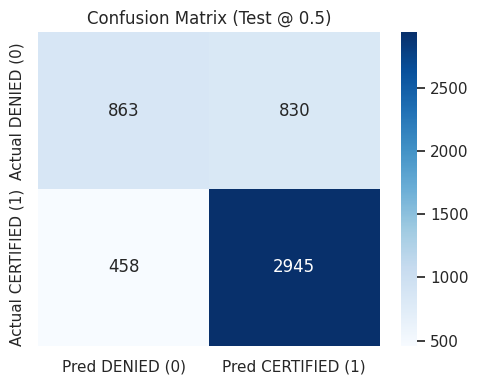

In [14]:
# ============================================================
# 13) Final Evaluation on TEST (Default 0.5 threshold)
#     - Full metric table (incl. specificity for DENIED)
#     - Confusion matrix
# ============================================================
y_pred_test = best_model.predict(X_test)
try:
    y_prob_test = best_model.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(y_test, y_prob_test)
except Exception:
    y_prob_test = None
    auc_test = np.nan

acc  = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec  = recall_score(y_test, y_pred_test)
f1   = f1_score(y_test, y_pred_test)
cm   = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
spec_denied = tn/(tn+fp) if (tn+fp) else np.nan

print("=== Final (Test) — Default 0.5 Cutoff ===")
display(pd.DataFrame({
    "Accuracy":[acc], "Precision(1)":[prec], "Recall(1)":[rec], "F1(1)":[f1], "Spec(0)":[spec_denied], "ROC_AUC":[auc_test]
}).round(4))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=["Denied(0)","Certified(1)"]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Pred DENIED (0)","Pred CERTIFIED (1)"],
            yticklabels=["Actual DENIED (0)","Actual CERTIFIED (1)"])
plt.title("Confusion Matrix (Test @ 0.5)"); plt.tight_layout(); plt.show()

In [15]:
# ============================================================
# Step 13C — Test Evaluation @ Selected Thresholds
#   Evaluates at:
#     1) Best-F1 threshold
#     2) Balanced (~50/50) threshold
#   Shows correct & incorrect counts for each class
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_test_num = to_numeric01(y_test)
test_prob  = proba_positive(best_model, X_test)

def evaluate_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    cm   = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return {
        "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc,
        "spec": spec, "tn": tn, "fp": fp, "fn": fn, "tp": tp, "thr": thr
    }

res_best = evaluate_threshold(y_test_num, test_prob, VAL_best_f1_threshold)
res_bal  = evaluate_threshold(y_test_num, test_prob, VAL_balanced_threshold)

def print_results(title, res):
    print(f"\n=== {title} ===")
    print(f"Threshold              : {res['thr']:.3f}")
    print(f"Accuracy               : {res['acc']:.4f}")
    print(f"Precision (Certified)  : {res['prec']:.4f}")
    print(f"Recall (Certified)     : {res['rec']:.4f}")
    print(f"F1 (Certified)         : {res['f1']:.4f}")
    print(f"Specificity (Denied)   : {res['spec']:.4f}")
    print(f"ROC-AUC                : {res['auc']:.4f}\n")

    total_denied = res["tn"] + res["fp"]
    total_cert   = res["tp"] + res["fn"]

    print("🔹 Correct Predictions:")
    print(f"   - DENIED correctly predicted:   {res['tn']} / {total_denied}  ({res['tn']/total_denied:.2%})")
    print(f"   - CERTIFIED correctly predicted: {res['tp']} / {total_cert}  ({res['tp']/total_cert:.2%})")
    print("\n🔸 Incorrect Predictions:")
    print(f"   - DENIED misclassified as CERTIFIED: {res['fp']}")
    print(f"   - CERTIFIED misclassified as DENIED: {res['fn']}")

    cm_df = pd.DataFrame(
        [[res["tn"], res["fp"]], [res["fn"], res["tp"]]],
        index=["Actual DENIED (0)", "Actual CERTIFIED (1)"],
        columns=["Pred DENIED (0)", "Pred CERTIFIED (1)"]
    )
    print("\nConfusion Matrix:")
    display(cm_df)

# ---- Print results ----
print_results("Test Performance @ Best-F1 Threshold", res_best)
print_results("Test Performance @ Balanced Threshold (~50/50)", res_bal)

NameError: name 'to_numeric01' is not defined

In [ ]:
# ============================================================
# 14) Operating Threshold Selection (Validation-driven)
#     - Tune cutoff to balance DEcity and CENIED specifiRTIFIED recall
#     - Re-evaluate on TEST at chosen threshold
# ============================================================
def proba_positive(est, X):
    clf = est.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        return est.predict_proba(X)[:,1]
    raise RuntimeError("Estimator lacks predict_proba for threshold tuning.")

val_prob = proba_positive(best_model, X_valid)

thresholds = np.linspace(0.20, 0.80, 121)
records = []
for t in thresholds:
    y_pred = (val_prob >= t).astype(int)
    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec  = recall_score(y_valid, y_pred, zero_division=0)            # Certified recall
    f1   = f1_score(y_valid, y_pred, zero_division=0)
    cm   = confusion_matrix(y_valid, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec0 = tn/(tn+fp) if (tn+fp) else 0.0                           # Denied specificity
    # Objective: near-balanced: high F1 and reasonable specificity
    score = 0.6*f1 + 0.4*spec0
    records.append([t, acc, prec, rec, f1, spec0, score])

thresh_df = pd.DataFrame(records, columns=["threshold","accuracy","precision(1)","recall(1)","f1(1)","spec(0)","score"])\
             .sort_values(by="score", ascending=False).reset_index(drop=True)

best_thr = float(thresh_df.iloc[0]["threshold"])
print("=== Threshold Tuning (Validation) ===")
print(f"Chosen threshold: {best_thr:.3f}")
display(thresh_df.head(10).round(4))

# Test @ chosen threshold
test_prob = proba_positive(best_model, X_test)
y_pred_thr = (test_prob >= best_thr).astype(int)

acc  = accuracy_score(y_test, y_pred_thr)
prec = precision_score(y_test, y_pred_thr, zero_division=0)
rec  = recall_score(y_test, y_pred_thr, zero_division=0)
f1   = f1_score(y_test, y_pred_thr, zero_division=0)
cm   = confusion_matrix(y_test, y_pred_thr, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
spec0 = tn/(tn+fp) if (tn+fp) else 0.0
auc  = roc_auc_score(y_test, test_prob)

print("\n=== Final Test @ Chosen Threshold ===")
display(pd.DataFrame({
    "Threshold":[best_thr],
    "Accuracy":[acc],
    "Precision(1)":[prec],
    "Recall(1)":[rec],
    "F1(1)":[f1],
    "Spec(0)":[spec0],
    "ROC_AUC":[auc]
}).round(4))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens",
            xticklabels=["Pred DENIED (0)","Pred CERTIFIED (1)"],
            yticklabels=["Actual DENIED (0)","Actual CERTIFIED (1)"])
plt.title(f"Confusion Matrix (Test @ {best_thr:.3f})"); plt.tight_layout(); plt.show()

In [ ]:
# ============================================================
# 15) Model Performance Summary (Validation & Test)
#     - Consolidate best validation and final test metrics
# ============================================================
summary = {
    "Best Tuned (Validation)": best_name,
    "Chosen Threshold (Val)": round(best_thr, 3)
}
print(summary)